# Lab 1: Single Node GPUs and Optimizations

In this lab we will demonstrate how you can optomize code to fully leverage a GPUs resources. This will leverage the roofline model concepts as well as algorithmic intensity to demonstrate these foundational concepts in action.

### Pre-requsite Knowledge
We highly suggest you read up on the [roofline model](https://jax-ml.github.io/scaling-book/roofline/), this is more about execution than education of the concept itself.

We will be using [GEMM operations](https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#) so we suggest you learn a bit about those before diving in.

Understanding basic [GPU hardware](https://www.cudocompute.com/blog/a-beginners-guide-to-nvidia-gpus) will be helpful.

### In This Lab You Will:
- Run a series of benchmarks using synthetic GEMM workloads.
- Visualize performance using a **Roofline model**.
- Learn how to identify when you're **memory-bound**, **bandwidth-bound**, or **compute-bound**.
- See how performance improves with **batching** even on a single GPU.

In the **next lab**, we will expand on these concepts by distributing the workload across **multiple GPUs** using a distributed training framework. This will demonstrate how to scale beyond a single node and identify new bottlenecks as compute capacity increases.

Let's get started.

## Imports and GPU Information
Here we import the relevant libraries and retrieve detailed information about the available GPUs in our environment. We use pynvml to get low-level GPU metrics (e.g., name, memory size, clock speeds), and set up any necessary environment variables (like PyTorch memory allocations). This step helps us understand and confirm our hardware configuration.

In [ ]:
%pip install transformers torch pynvml matplotlib numpy

In [38]:
import torch
import pynvml
import os

# Configure PyTorch memory
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

pynvml.nvmlInit()
num_gpus = pynvml.nvmlDeviceGetCount()
memory_bandwidth_tb_s = 0.3

print(f"Available GPUs: {num_gpus}")

gpu_info = {}
for i in range(num_gpus):
    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
    name = pynvml.nvmlDeviceGetName(handle)
    memory_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    mem_total_tb = memory_info.total / (1024 ** 3)
    clock_info = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_GRAPHICS)
    mem_clock_info = pynvml.nvmlDeviceGetClockInfo(handle, pynvml.NVML_CLOCK_MEM)
    compute_capability = torch.cuda.get_device_capability(i)
    
    gpu_info[i] = {
        'name': name,
        'memory_tb': mem_total_tb,
        'gpu_clock_mhz': clock_info,
        'mem_clock_mhz': mem_clock_info,
        'memory_bandwidth_tb_s': memory_bandwidth_tb_s,
        'compute_capability': compute_capability
    }
    
    print(f"GPU {i}: {name}")
    print(f"  Memory: {mem_total_tb:.2f} GB")
    print(f"  GPU Clock: {clock_info} MHz")
    print(f"  Memory Clock: {mem_clock_info} MHz")
    print(f"  Approx. Memory Bandwidth: {memory_bandwidth_tb_s:.2f} TB/s")
    print(f"  Compute Capability: {compute_capability}")

gpu_info = [gpu_info[0]]

pynvml.nvmlShutdown()
print("\nNote: For detailed CUDA core and tensor core counts, refer to NVIDIA official GPU specifications.")


Available GPUs: 4
GPU 0: NVIDIA L4
  Memory: 22.49 GB
  GPU Clock: 2040 MHz
  Memory Clock: 6251 MHz
  Approx. Memory Bandwidth: 0.30 TB/s
  Compute Capability: (8, 9)
GPU 1: NVIDIA L4
  Memory: 22.49 GB
  GPU Clock: 210 MHz
  Memory Clock: 405 MHz
  Approx. Memory Bandwidth: 0.30 TB/s
  Compute Capability: (8, 9)
GPU 2: NVIDIA L4
  Memory: 22.49 GB
  GPU Clock: 210 MHz
  Memory Clock: 405 MHz
  Approx. Memory Bandwidth: 0.30 TB/s
  Compute Capability: (8, 9)
GPU 3: NVIDIA L4
  Memory: 22.49 GB
  GPU Clock: 210 MHz
  Memory Clock: 405 MHz
  Approx. Memory Bandwidth: 0.30 TB/s
  Compute Capability: (8, 9)

Note: For detailed CUDA core and tensor core counts, refer to NVIDIA official GPU specifications.


We see 4 GPUs here but we'll only be focused on the first 1

## The Roofline Model 

The roofline model is a visual performance model that helps us understand the limitations of a computing system, particularly the trade-offs between compute capabilities and memory bandwidth. It plots the achievable performance (typically in TFLOPs) against the arithmetic intensity (FLOPs per byte of memory accessed).

- **Memory-Bound Region:** At low arithmetic intensities, performance is limited by memory bandwidth. In this region, increasing the arithmetic intensity (doing more computation per memory byte) can lead to significant performance improvements.
- **Compute-Bound Region:** At high arithmetic intensities, performance is capped by the peak compute performance of the GPU. Here, even if you increase arithmetic intensity, the performance will not exceed the hardware’s compute limits.
- **Ideal Performance:** The ideal performance on the roofline model is represented by the "roof" — the lowest boundary defined by the compute peak and the memory bandwidth limit. Achieving performance close to this roof indicates that the application is efficiently utilizing the GPU resources, whether it is memory-bound or compute-bound.

This model helps in identifying if your workload is being limited by the speed at which data is moved (memory bandwidth) or by the raw computational power (compute throughput), guiding further optimizations.

Let's look at the roofline model for our current GPU.


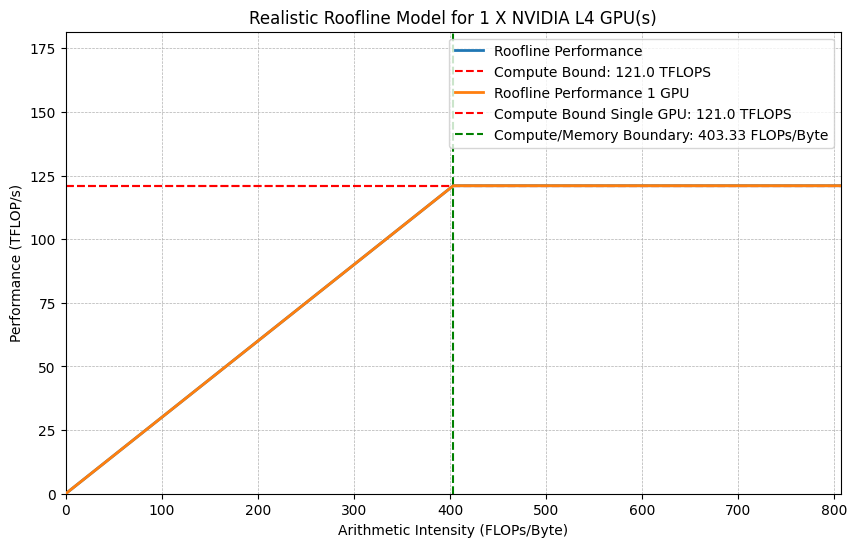

In [39]:
import importlib
import utils.plot_utils as putils
importlib.reload(putils)

# Generate an empty roofline model
putils.plot_roofline_chart(gpu_info, [])

### Determining the Ideal Arithmetic Intensity
How do we determine this graph? We need to find the ideal AI for our GPU. This will differ for each GPU.

For our GPU (L4), the ideal arithmetic intensity is derived by comparing the hardware's compute capability and its memory bandwidth. Here's how we determined it:

1. **Peak Compute Performance:**  
   We consider the GPU's theoretical peak compute performance (in TFLOPs). For example, our GPU's peak (for FP 16) is set at 121 TFLOPs, which represents the maximum number of floating-point operations it can perform per second. In our case that is **121 TFLOPs**

2. **Memory Bandwidth:**  
   The memory bandwidth (in TB/s) indicates how quickly data can be moved between the GPU memory and its compute cores. In our setup, we use a value extracted from the GPU information, in our case it's **0.3 TB/s**. 

3. **Ideal Arithmetic Intensity (Cross Point):**  
   The ideal arithmetic intensity is the point where the compute-bound performance and the memory-bound performance intersect. It is computed as:
   
$$
\text{AI} = \frac{\text{FLOPs}_{\text{total}}}{\text{Memory}_{\text{total}}} 
$$

For our values, this gives:

$$
\text{Ideal AI} = \frac{121\text{ TFLOPs}}{0.3\text{ TB/s}} \approx 403.33\text{ FLOPs/Byte}
$$

This essentially means for every Byte we load into memory, we should be performing 403 operations in order to take full advantage of our GPU.

Moving forward that is what we will try to achieve.

### Determining Algorithmic Intensity of our Algorithm
Now we need to determine the algorithmic intensity for our specific algorithm. For the purposes of this workshop we are doing simple GEMM operations, or generic matrix multiplications multiple times. We load data of size BD and DF into memory, do a matrix multiplication, which will equate to one flop per byte. Then for each layer we repeat this. Finally we write the data back to memory. Below is a basic example of this with a low Algorithmic Intensity.

**Given Configuration:**  
Batch size, dimension, weight size, and layer count are:

$B = 1,\ D = 4096,\ F = 4096,\ L = 5.$

---

**1. Calculate Total FLOPs**  
The total number of floating-point operations (FLOPs) is calculated by summing the operations from the first layer and all remaining layers. The first layer multiplies a $[B, D]$ matrix with a $[D, F]$ matrix, while each additional layer multiplies $[B, F]$ by $[F, F]$.

$$
\begin{aligned}
\text{FLOPs}_{\text{first}} &= 2 \cdot B \cdot D \cdot F = 2 \cdot 1 \cdot 4096 \cdot 4096 = 33\,554\,432,\\[1mm]
\text{FLOPs}_{\text{other}} &= (L-1) \cdot (2 \cdot B \cdot F \cdot F) = 4 \cdot (2 \cdot 1 \cdot 4096 \cdot 4096) = 134\,217\,728,\\[1mm]
\text{FLOPs}_{\text{total}} &= \text{FLOPs}_{\text{first}} + \text{FLOPs}_{\text{other}} = 33\,554\,432 + 134\,217\,728 = 167\,772\,160.
\end{aligned}
$$

---

**2. Estimate Memory Traffic (in Bytes)**  
We estimate the amount of memory read and written (in bytes) by accounting for inputs, weights, and outputs. All tensors use FP16 (2 bytes per element). The memory access pattern is similar for each layer.

$$
\begin{aligned}
\text{Memory}_{\text{first}} &= \Big( B\cdot D + D\cdot F + B\cdot F \Big) \times 2 \\
&= \Big( 4096 + (4096 \times 4096) + 4096 \Big) \times 2 = 33\,570\,816\text{ bytes},\\[1mm]
\text{Memory}_{\text{layer}} &= \Big( B\cdot F + F\cdot F + B\cdot F \Big) \times 2 \\
&= \Big( 4096 + (4096 \times 4096) + 4096 \Big) \times 2 = 33\,570\,816\text{ bytes},\\[1mm]
\text{Memory}_{\text{other}} &= (L-1) \cdot \text{Memory}_{\text{layer}} = 4 \times 33\,570\,816 = 134\,283\,264\text{ bytes},\\[1mm]
\text{Memory}_{\text{total}} &= \text{Memory}_{\text{first}} + \text{Memory}_{\text{other}} = 33\,570\,816 + 134\,283\,264 = 167\,854\,080\text{ bytes}.
\end{aligned}
$$

---

**3. Compute Arithmetic Intensity (AI)**  
Arithmetic intensity is defined as the ratio of total FLOPs to total memory bytes accessed. This tells us how much computation is performed per byte transferred.

$$
\text{AI} = \frac{\text{FLOPs}_{\text{total}}}{\text{Memory}_{\text{total}}} \approx \frac{167\,772\,160}{167\,854\,080} \approx 1\text{ FLOP/Byte.}
$$

---

This result shows that this configuration performs approximately one floating-point operation per byte accessed, meaning it's in the **memory-bound** region of the roofline model.


### In Practice
Below we'll actually run the algorithm we described. We suggest running `watch nvidia-smi` in a terminal to see the memory and compute usage go up.

In [40]:
import importlib
import utils.gemm_multigpu_benchmark as butils
importlib.reload(butils)

import json

test_suite = { # 1 GPU
        "world_size": 1, 
        "tests": [
            {"batch_size": 1, "D": 4096, "F": 4096, "num_layers": 5}, 
        ]
    }

results = []
butils.distributed_main(0, test_suite["world_size"], test_suite["tests"])
with open(f"results/distributed_test_suite_results_{world_size}gpus.json", "r") as f:
    results.append(json.load(f))

print(json.dumps(results, indent=2))


Rank 0 running on GPU 0
PASSED: B=1, D=4096, F=4096, layers=5
  Local GFLOPs: 223.55  |  Aggregated GFLOPs: 223.55
  Total FLOPs: 1.68e+08  |  Estimated Memory: 1.68e+08
  Arithmetic Intensity: 1.000
--------------------------------------------------------------------------------

Test suite complete. Results saved to results/distributed_test_suite_results_1gpus.json


[
  [
    {
      "batch_size": 1,
      "world_size": 1,
      "D": 4096,
      "F": 4096,
      "num_layers": 5,
      "avg_time_seconds": 0.0007504940032958985,
      "local_gflops": 223.54896809728697,
      "aggregated_gflops": 223.54896545410156,
      "total_flops": 167772160.0,
      "estimated_memory_bytes": 167854080.0,
      "arithmetic_intensity": 0.9995119570522206
    }
  ]
]


### Construct Roofline Chart
Let's place our newly found data point on the roofline model. Where do you think it will land? Look at the empty one above and give a guess

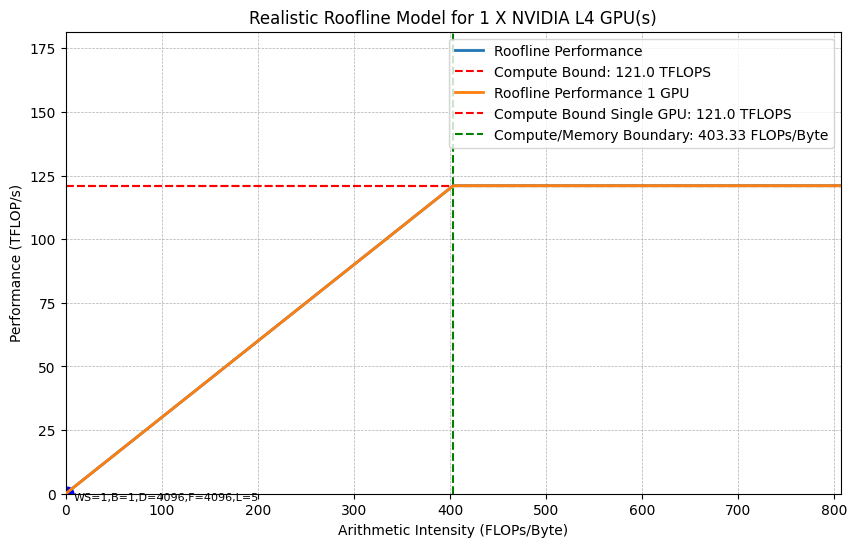

In [41]:
import importlib
import utils.plot_utils as putils
importlib.reload(putils)

# Now use it
putils.plot_roofline_chart(gpu_info, results)


Not great. This essentially means our GPU is idle waiting to load data in and out of memory.

It looks like we're heavily constrained by memory bandwidth, and we need to increase our algorithmic intensity. The easiest way to do this is by increasing the batch size. This is because it increases the amount of data we procesess per byte we load into memory. Try to estimate it with the previous algorithm we showed. 

Once you're ready run the code below to see a beter usage of our GPU. We've just increased the batch size.

Rank 0 running on GPU 0


PASSED: B=512, D=4096, F=4096, layers=5
  Local GFLOPs: 77732.03  |  Aggregated GFLOPs: 77732.03
  Total FLOPs: 8.59e+10  |  Estimated Memory: 2.10e+08
  Arithmetic Intensity: 409.600
--------------------------------------------------------------------------------

Test suite complete. Results saved to results/distributed_test_suite_results_1gpus.json


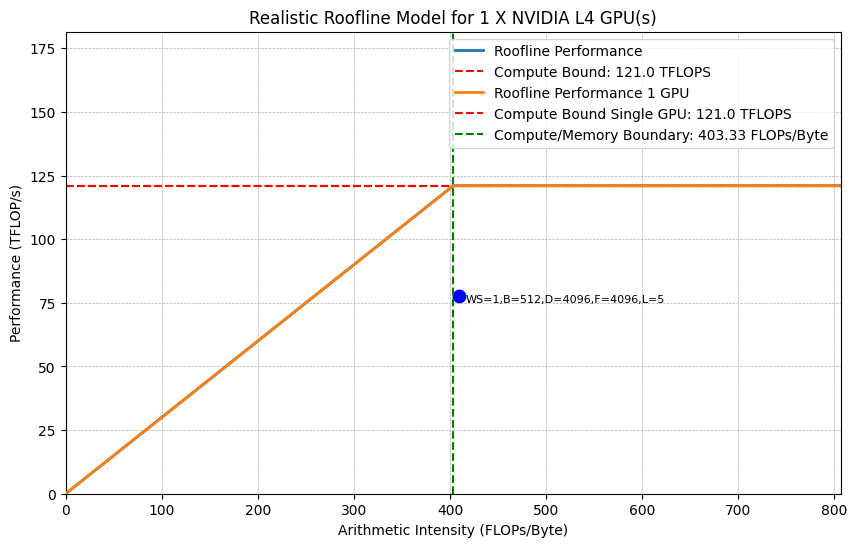

In [42]:
test_suite = { # 1 GPU
        "world_size": 1, 
        "tests": [
            {"batch_size": 512, "D": 4096, "F": 4096, "num_layers": 5}, 
        ]
    }

results = []
butils.distributed_main(0, test_suite["world_size"], test_suite["tests"])
with open(f"results/distributed_test_suite_results_{world_size}gpus.json", "r") as f:
    results.append(json.load(f))
    
putils.plot_roofline_chart(gpu_info, results)


Much better!

Why is it not capping out though at TFLOPS? It should hit around 75? The reason is memory bandwidth isn't the only bottleneck, this is where you can continue to dive into optimizations to ensure you're leveraging your GPU effectively, but for now we'll stop here as this is the biggest factor, as you scale, to leverage your GPU appropriately.

In the next lab we will run a workload on multiple GPUs, and introduce distribution frameworks.

### Appendix
Multiple tests. Play around with this to see how changing different variables effects your chart. You'll see batch size effects it but so does your "sequence length" or data size, and your "weight" size. The more data you operate on, the more effeciently you're leveraging your compute. But be careful! You don't want to run out of memory.

Rank 0 running on GPU 0
PASSED: B=1, D=4096, F=4096, layers=5
  Local GFLOPs: 224.60  |  Aggregated GFLOPs: 224.60
  Total FLOPs: 1.68e+08  |  Estimated Memory: 1.68e+08
  Arithmetic Intensity: 1.000
--------------------------------------------------------------------------------
PASSED: B=128, D=4096, F=4096, layers=5
  Local GFLOPs: 28583.39  |  Aggregated GFLOPs: 28583.39
  Total FLOPs: 2.15e+10  |  Estimated Memory: 1.78e+08
  Arithmetic Intensity: 120.471
--------------------------------------------------------------------------------
PASSED: B=256, D=4096, F=4096, layers=5
  Local GFLOPs: 55603.43  |  Aggregated GFLOPs: 55603.43
  Total FLOPs: 4.29e+10  |  Estimated Memory: 1.89e+08
  Arithmetic Intensity: 227.556
--------------------------------------------------------------------------------
PASSED: B=512, D=4096, F=4096, layers=5
  Local GFLOPs: 77654.96  |  Aggregated GFLOPs: 77654.96
  Total FLOPs: 8.59e+10  |  Estimated Memory: 2.10e+08
  Arithmetic Intensity: 409.600
-----

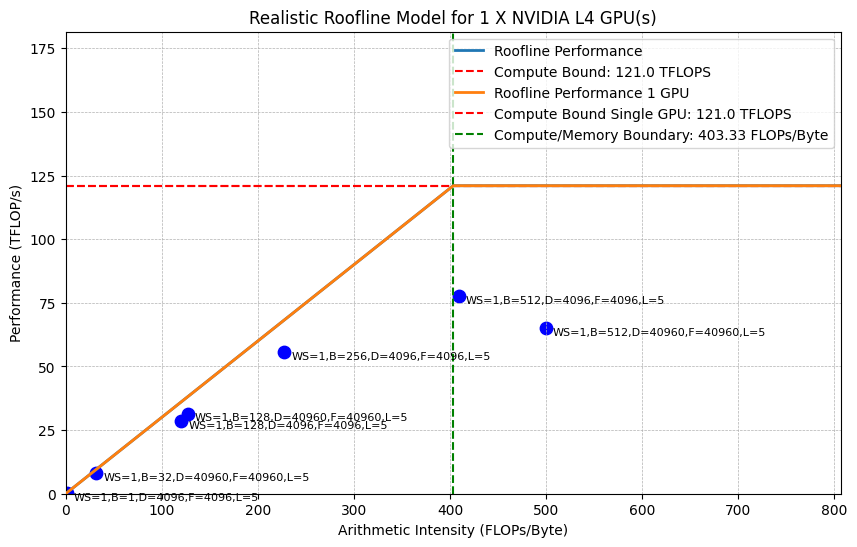

In [43]:
# Define your custom test suite
test_suite = { # 1 GPU
        "world_size": 1, 
        "tests": [
            {"batch_size": 1,   "D": 4096,  "F": 4096,  "num_layers": 5},
            {"batch_size": 128, "D": 4096,  "F": 4096,  "num_layers": 5},
            {"batch_size": 256, "D": 4096,  "F": 4096,  "num_layers": 5},
            {"batch_size": 512, "D": 4096,  "F": 4096,  "num_layers": 5},
            {"batch_size": 32,  "D": 40960, "F": 40960, "num_layers": 5},
            {"batch_size": 128, "D": 40960, "F": 40960, "num_layers": 5},
            {"batch_size": 512, "D": 40960, "F": 40960, "num_layers": 5},
        ]
    }

results = []
butils.distributed_main(0, test_suite["world_size"], test_suite["tests"])
with open(f"results/distributed_test_suite_results_{world_size}gpus.json", "r") as f:
    results.append(json.load(f))
    
putils.plot_roofline_chart(gpu_info, results)
